In [ ]:
# !pip uninstall -y scikit-learn imbalanced-learn
# !pip cache purge

In [ ]:
# !pip install scikit-learn==1.4.2 imbalanced-learn==0.12.2

In [1]:
import sklearn
import imblearn

print("scikit-learn version:", sklearn.__version__)
print("imbalanced-learn version:", imblearn.__version__)

scikit-learn version: 1.4.2
imbalanced-learn version: 0.12.2


In [2]:
import pandas as pd
import numpy as np 
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "fraudTest.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "kartik2112/fraud-detection",
  file_path )

df.rename( columns = {"Unnamed: 0" : "_id"})
df.set_index(df.columns[0], inplace=True)

In [4]:
df.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

In [5]:
def haversine_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    r = 6371  
    return r * c

In [6]:
df['haversine_distance'] = df.apply(
    lambda x : haversine_distance(x['lat'], x['long'], x['merch_lat'], x['merch_long']) , 
    axis = 1 )

In [7]:
df['trans_datetime'] = pd.to_datetime(df['unix_time'], unit='s')
df['hour'] = df['trans_datetime'].dt.hour
df['day'] = df['trans_datetime'].dt.day
df['dayofweek'] = df['trans_datetime'].dt.dayofweek  # Monday=0, Sunday=6
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 555719 entries, 0 to 555718
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trans_date_trans_time  555719 non-null  object        
 1   cc_num                 555719 non-null  int64         
 2   merchant               555719 non-null  object        
 3   category               555719 non-null  object        
 4   amt                    555719 non-null  float64       
 5   first                  555719 non-null  object        
 6   last                   555719 non-null  object        
 7   gender                 555719 non-null  object        
 8   street                 555719 non-null  object        
 9   city                   555719 non-null  object        
 10  state                  555719 non-null  object        
 11  zip                    555719 non-null  int64         
 12  lat                    555719 non-null  float64  

In [9]:
num_cols = []
cat_cols = []
for i in df.columns :
    if df[i].dtype in ["int64" , "float64","int32" , "datetime64[ns]"] :
        num_cols.append(i)
    else :
        cat_cols.append(i)

In [10]:
df_nums = df[num_cols]
df_nums.head()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,haversine_distance,trans_datetime,hour,day,dayofweek,is_weekend
Unnamed: 0,,,,,,,,,,,,,,,,
0,2291163933867244,2.86,29209,33.9659,-80.9355,333497,1371816865,33.986391,-81.200714,0,24.561462,2013-06-21 12:14:25,12,21,4,0
1,3573030041201292,29.84,84002,40.3207,-110.4360,302,1371816873,39.450498,-109.960431,0,104.925092,2013-06-21 12:14:33,12,21,4,0
2,3598215285024754,41.28,11710,40.6729,-73.5365,34496,1371816893,40.495810,-74.196111,0,59.080078,2013-06-21 12:14:53,12,21,4,0
3,3591919803438423,60.05,32780,28.5697,-80.8191,54767,1371816915,28.812398,-80.883061,0,27.698567,2013-06-21 12:15:15,12,21,4,0
4,3526826139003047,3.19,49632,44.2529,-85.0170,1126,1371816917,44.959148,-85.884734,0,104.335106,2013-06-21 12:15:17,12,21,4,0


In [11]:
for i in cat_cols :
    df_nums[i] = df[i].astype("category").cat.codes

In [12]:
col = df_nums.pop('is_fraud')
df_nums['is_fraud'] = col

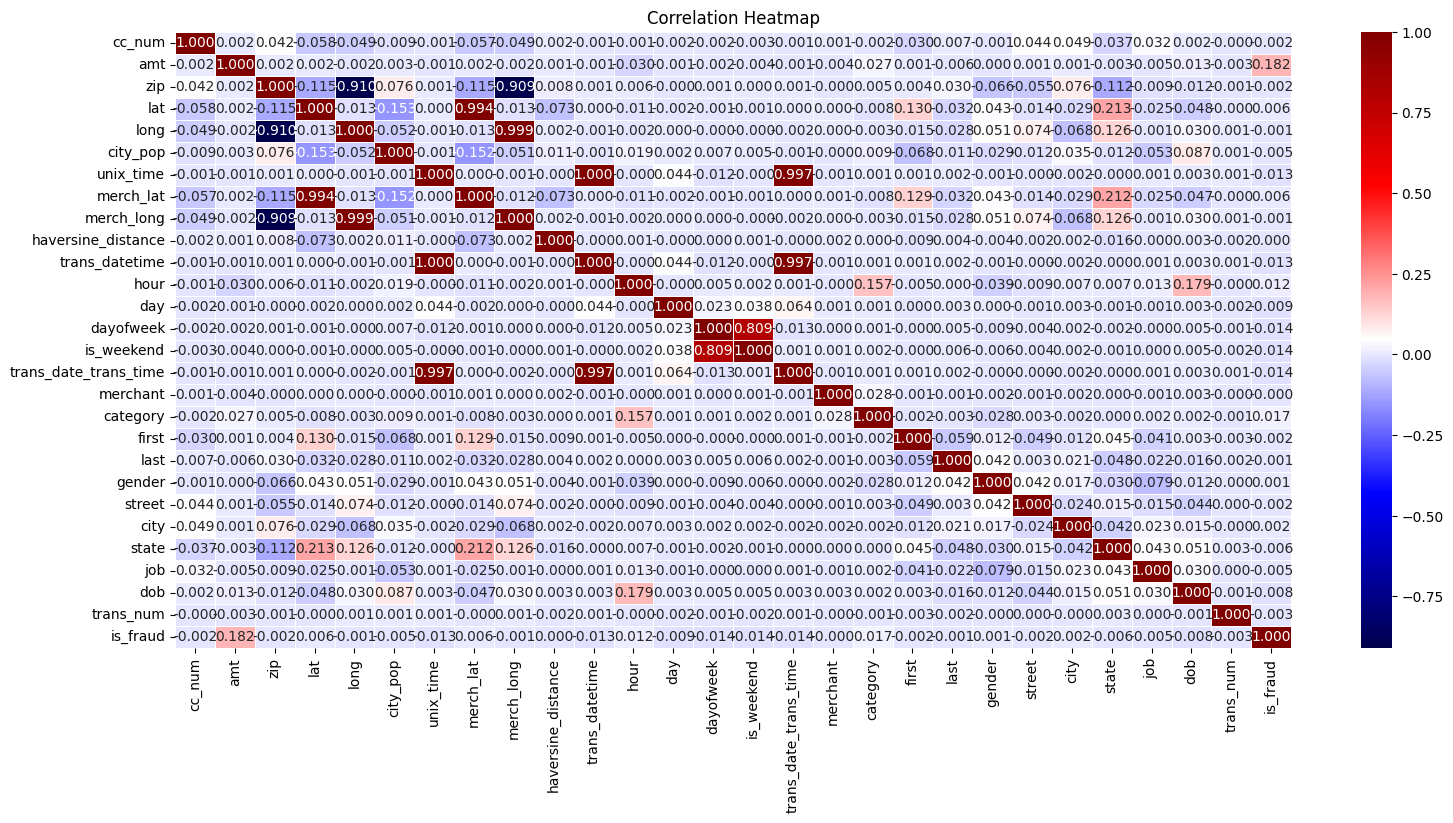

In [22]:
plt.figure(figsize=(18, 8))
sns.heatmap(df_nums.corr(), annot=True , cmap="seismic", fmt=".3f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [23]:
cols_drop = [
    "cc_num","trans_num", "first", "last",    
    "street", "city", "state", "zip",  
    "dob",   "trans_date_trans_time",  "merchant" , 
    'lat', 'long', 'merch_lat', 'merch_long'  ,
    'unix_time', 'trans_datetime',"is_weekend"
]

In [24]:
choosen_cols = [i for i in df.columns if i not in cols_drop]

In [25]:
choosen_cols

['category',
 'amt',
 'gender',
 'city_pop',
 'job',
 'is_fraud',
 'haversine_distance',
 'hour',
 'day',
 'dayofweek']

In [26]:
df.drop(columns = cols_drop , inplace = True )

In [27]:
df.head()

,category,amt,gender,city_pop,job,is_fraud,haversine_distance,hour,day,dayofweek
Unnamed: 0,,,,,,,,,,
0,personal_care,2.86,M,333497,Mechanical engineer,0,24.561462,12,21,4
1,personal_care,29.84,F,302,"Sales professional, IT",0,104.925092,12,21,4
2,health_fitness,41.28,F,34496,"Librarian, public",0,59.080078,12,21,4
3,misc_pos,60.05,M,54767,Set designer,0,27.698567,12,21,4
4,travel,3.19,M,1126,Furniture designer,0,104.335106,12,21,4


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 555719 entries, 0 to 555718
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   category            555719 non-null  object 
 1   amt                 555719 non-null  float64
 2   gender              555719 non-null  object 
 3   city_pop            555719 non-null  int64  
 4   job                 555719 non-null  object 
 5   is_fraud            555719 non-null  int64  
 6   haversine_distance  555719 non-null  float64
 7   hour                555719 non-null  int32  
 8   day                 555719 non-null  int32  
 9   dayofweek           555719 non-null  int32  
dtypes: float64(2), int32(3), int64(2), object(3)
memory usage: 40.3+ MB


In [29]:
target = "is_fraud"
time_cols = ['hour',"day", "dayofweek"]
cat_cols = ["category" , "gender" , "job"]
num_cols = [i for i in df.columns if i not in cat_cols and i not in time_cols and i != target ]
num_cols , cat_cols , time_cols

(['amt', 'city_pop', 'haversine_distance'],
 ['category', 'gender', 'job'],
 ['hour', 'day', 'dayofweek'])

In [30]:
df_scaled = df.drop(columns = ["is_fraud"])
df_scaled.head(3)

,category,amt,gender,city_pop,job,haversine_distance,hour,day,dayofweek
Unnamed: 0,,,,,,,,,
0,personal_care,2.86,M,333497,Mechanical engineer,24.561462,12,21,4
1,personal_care,29.84,F,302,"Sales professional, IT",104.925092,12,21,4
2,health_fitness,41.28,F,34496,"Librarian, public",59.080078,12,21,4


In [31]:
from sklearn.preprocessing import OrdinalEncoder

orde = OrdinalEncoder()
df_scaled[cat_cols] = orde.fit_transform(df[cat_cols])

In [32]:
orde.n_features_in_ , orde.categories_[:2]

(3,
 [array(['entertainment', 'food_dining', 'gas_transport', 'grocery_net',
         'grocery_pos', 'health_fitness', 'home', 'kids_pets', 'misc_net',
         'misc_pos', 'personal_care', 'shopping_net', 'shopping_pos',
         'travel'], dtype=object),
  array(['F', 'M'], dtype=object)])

In [33]:
df_scaled

,category,amt,gender,city_pop,job,haversine_distance,hour,day,dayofweek
Unnamed: 0,,,,,,,,,
0,10.0,2.86,1.0,333497,275.0,24.561462,12,21,4
1,10.0,29.84,0.0,302,392.0,104.925092,12,21,4
2,5.0,41.28,0.0,34496,259.0,59.080078,12,21,4
3,9.0,60.05,1.0,54767,407.0,27.698567,12,21,4
4,13.0,3.19,1.0,1126,196.0,104.335106,12,21,4
...,...,...,...,...,...,...,...,...,...
555714,5.0,43.77,1.0,519,460.0,77.026148,23,31,1
555715,7.0,111.84,1.0,28739,198.0,100.074420,23,31,1
555716,7.0,86.88,0.0,3684,294.0,80.759302,23,31,1


In [34]:
df_scaled.columns

Index(['category', 'amt', 'gender', 'city_pop', 'job', 'haversine_distance',
       'hour', 'day', 'dayofweek'],
      dtype='object')

In [35]:
from sklearn.preprocessing import StandardScaler
cols_to_scale = ['city_pop', 'haversine_distance', 'hour', 'day', 'dayofweek']

scaler = StandardScaler()
df_scaled[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])


In [36]:
from sklearn.preprocessing import MinMaxScaler

min_max = MinMaxScaler()
df_scaled["amt"] = min_max.fit_transform(df[["amt"]])

In [37]:
df_scaled.head(3)

,category,amt,gender,city_pop,job,haversine_distance,hour,day,dayofweek
Unnamed: 0,,,,,,,,,
0,10.0,0.000082,1.0,0.816521,275.0,-1.770215,-0.118789,0.506526,0.221931
1,10.0,0.001267,0.0,-0.292685,392.0,0.989805,-0.118789,0.506526,0.221931
2,5.0,0.001769,0.0,-0.178853,259.0,-0.584703,-0.118789,0.506526,0.221931


In [38]:
# df_scaled["is_fraud"] = df["is_fraud"]

In [39]:
df_scaled

,category,amt,gender,city_pop,job,haversine_distance,hour,day,dayofweek
Unnamed: 0,,,,,,,,,
0,10.0,0.000082,1.0,0.816521,275.0,-1.770215,-0.118789,0.506526,0.221931
1,10.0,0.001267,0.0,-0.292685,392.0,0.989805,-0.118789,0.506526,0.221931
2,5.0,0.001769,0.0,-0.178853,259.0,-0.584703,-0.118789,0.506526,0.221931
3,9.0,0.002594,1.0,-0.111371,407.0,-1.662474,-0.118789,0.506526,0.221931
4,13.0,0.000096,1.0,-0.289942,196.0,0.969542,-0.118789,0.506526,0.221931
...,...,...,...,...,...,...,...,...,...
555714,5.0,0.001879,1.0,-0.291963,460.0,0.031639,1.496265,1.623183,-1.305403
555715,7.0,0.004868,1.0,-0.198018,198.0,0.823212,1.496265,1.623183,-1.305403
555716,7.0,0.003772,0.0,-0.281427,294.0,0.159851,1.496265,1.623183,-1.305403


In [40]:
df_scaled

,category,amt,gender,city_pop,job,haversine_distance,hour,day,dayofweek
Unnamed: 0,,,,,,,,,
0,10.0,0.000082,1.0,0.816521,275.0,-1.770215,-0.118789,0.506526,0.221931
1,10.0,0.001267,0.0,-0.292685,392.0,0.989805,-0.118789,0.506526,0.221931
2,5.0,0.001769,0.0,-0.178853,259.0,-0.584703,-0.118789,0.506526,0.221931
3,9.0,0.002594,1.0,-0.111371,407.0,-1.662474,-0.118789,0.506526,0.221931
4,13.0,0.000096,1.0,-0.289942,196.0,0.969542,-0.118789,0.506526,0.221931
...,...,...,...,...,...,...,...,...,...
555714,5.0,0.001879,1.0,-0.291963,460.0,0.031639,1.496265,1.623183,-1.305403
555715,7.0,0.004868,1.0,-0.198018,198.0,0.823212,1.496265,1.623183,-1.305403
555716,7.0,0.003772,0.0,-0.281427,294.0,0.159851,1.496265,1.623183,-1.305403


In [102]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2 ,)
x_scaled = pd.DataFrame(pca.fit_transform(df_scaled))

In [104]:
x_scaled

,0,1
0,-33.244660,3.752524
1,-150.245364,3.747148
2,-17.245080,-1.240745
3,-165.244954,2.743737
4,45.754747,6.751643
...,...,...
555714,-218.244954,-1.186678
555715,43.754949,0.826367
555716,-52.245361,0.824334
555717,183.754583,6.828094


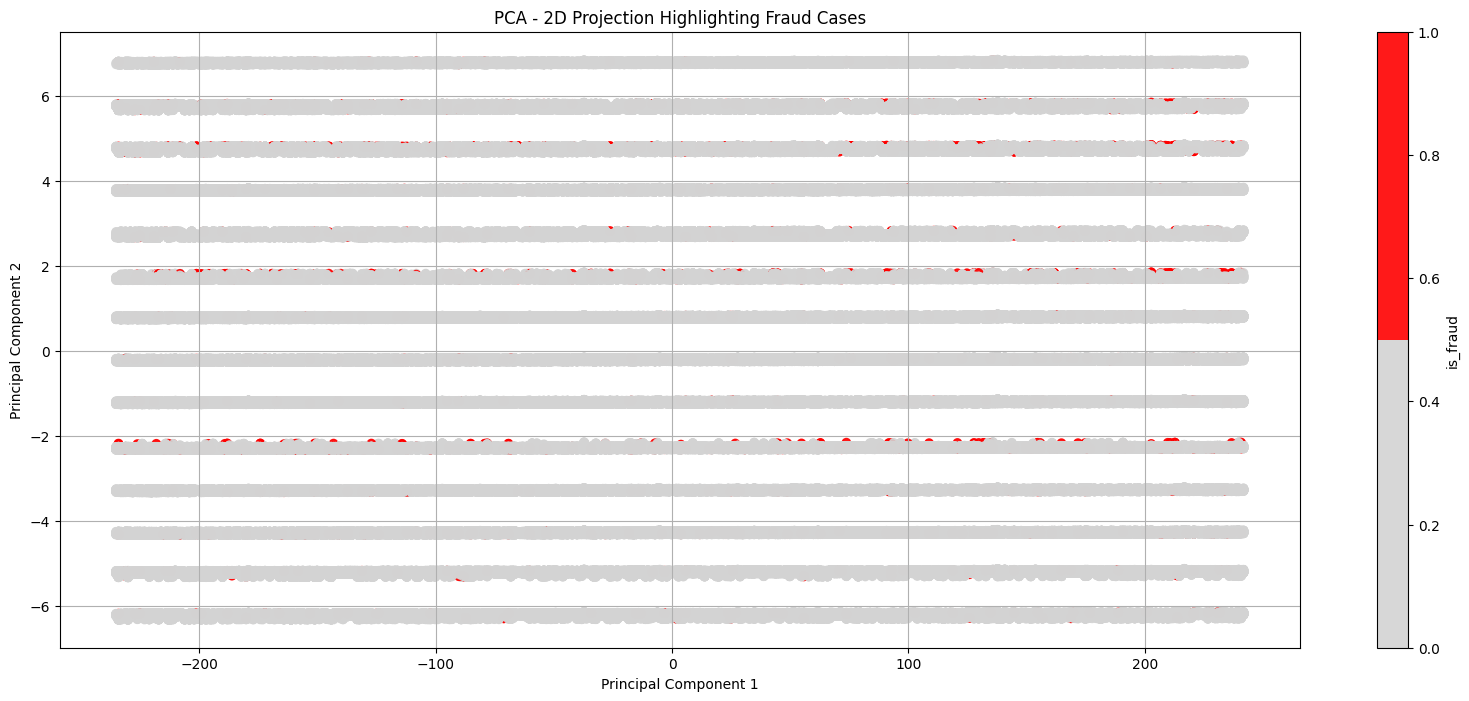

In [105]:
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(["#d3d3d3", "#ff0000"])  # light gray, bright red

plt.figure(figsize=(20, 8))
scatter = plt.scatter(
    x_scaled.iloc[:, 0],
    x_scaled.iloc[:, 1],
    c=df["is_fraud"],
    cmap=custom_cmap,
    alpha=0.9,
    # edgecolor='k'
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA - 2D Projection Highlighting Fraud Cases")
plt.colorbar(scatter, label="is_fraud")
plt.grid(True)
plt.show()

In [106]:
df["is_fraud"].value_counts()

is_fraud
0    553574
1      2145
Name: count, dtype: int64

### Smote and RandomnderSamplng

In [107]:
from sklearn.model_selection import train_test_split

xtrain  , xtest , ytrain ,  ytest = train_test_split( df_scaled , df["is_fraud"] , stratify = df["is_fraud"]  , shuffle = True , test_size = 0.2)

In [108]:
ytrain.value_counts()

is_fraud
0    442859
1      1716
Name: count, dtype: int64

In [109]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from tabulate import tabulate

def testScores(model, x, y):
    pred = model.predict(x)

    acc = accuracy_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    f1 = f1_score(y, pred)
    cm = confusion_matrix(y, pred)

    table = [["Accuracy", acc], ["Precision", prec], 
             ["Recall", rec], ["F1 Score", f1]]
    
    print(tabulate(table, headers=["Metric", "Score"], floatfmt=".4f", tablefmt="fancy_grid"))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()


In [110]:
# !pip install -U imbalanced-learn==0.12.2

In [111]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


sm = SMOTE(sampling_strategy= 0.1 ,
    k_neighbors=5,
    n_jobs=-1
)

# rus = RandomUnderSampler(sampling_strategy=0.5)

In [112]:
smTrain , smTest = sm.fit_resample( xtrain , ytrain)

In [113]:
smTest.value_counts()

is_fraud
0    442859
1     44285
Name: count, dtype: int64

In [114]:
rus = RandomUnderSampler(sampling_strategy = 0.5 , replacement = False )
rTrain , rTest = rus.fit_resample( smTrain , smTest )

In [115]:
rTest.value_counts()

is_fraud
0    88570
1    44285
Name: count, dtype: int64

In [116]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [117]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [118]:
rdf = RandomForestClassifier(
    n_estimators = 200 , 
    n_jobs = -1 ,
    class_weight='balanced'
)

avgAcc = []

for i , (train_idx, test_idx) in enumerate ( skf.split(rTrain, rTest) ) :
    #train rnd classifet
    X_tr, X_te = rTrain.iloc[train_idx], rTrain.iloc[test_idx]
    y_tr, y_te = rTest.iloc[train_idx], rTest.iloc[test_idx]


    rdf.fit(X_tr, y_tr)
    preds = rdf.predict(X_te)

    acc = accuracy_score(y_te, preds)
    avgAcc.append(acc)
    print(f"Fold {i+1} Accuracy: {acc:.4f}")

print(f"Average Accuracy : {(sum(avgAcc) / 5):.4f}")

Fold 1 Accuracy: 0.9944
Fold 2 Accuracy: 0.9942
Fold 3 Accuracy: 0.9935
Fold 4 Accuracy: 0.9939
Fold 5 Accuracy: 0.9942
Average Accuracy : 0.9941


╒═══════════╤═════════╕
│ Metric    │   Score │
╞═══════════╪═════════╡
│ Accuracy  │  0.9951 │
├───────────┼─────────┤
│ Precision │  0.4300 │
├───────────┼─────────┤
│ Recall    │  0.8228 │
├───────────┼─────────┤
│ F1 Score  │  0.5648 │
╘═══════════╧═════════╛


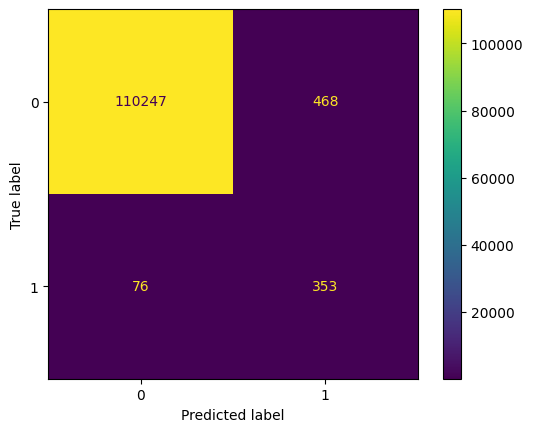

In [119]:
testScores( rdf , xtest , ytest )

In [120]:
from xgboost import XGBClassifier

In [121]:
xgb = XGBClassifier(
     n_estimators=100,
    n_jobs=-1,
    scale_pos_weight = 2.0 
)

avgAcc = []

for i , (train_idx, test_idx) in enumerate ( skf.split(rTrain, rTest) ) :
    #train rnd classifet
    X_tr, X_te = rTrain.iloc[train_idx], rTrain.iloc[test_idx]
    y_tr, y_te = rTest.iloc[train_idx], rTest.iloc[test_idx]


    xgb.fit(X_tr, y_tr)
    preds = xgb.predict(X_te)

    acc = accuracy_score(y_te, preds)
    avgAcc.append(acc)
    print(f"Fold {i+1} Accuracy: {acc:.4f}")

print(f"Average Accuracy : {(sum(avgAcc) / 5):.4f}")

Fold 1 Accuracy: 0.9965
Fold 2 Accuracy: 0.9957
Fold 3 Accuracy: 0.9960
Fold 4 Accuracy: 0.9965
Fold 5 Accuracy: 0.9964
Average Accuracy : 0.9962


╒═══════════╤═════════╕
│ Metric    │   Score │
╞═══════════╪═════════╡
│ Accuracy  │  0.9968 │
├───────────┼─────────┤
│ Precision │  0.5549 │
├───────────┼─────────┤
│ Recall    │  0.8951 │
├───────────┼─────────┤
│ F1 Score  │  0.6851 │
╘═══════════╧═════════╛


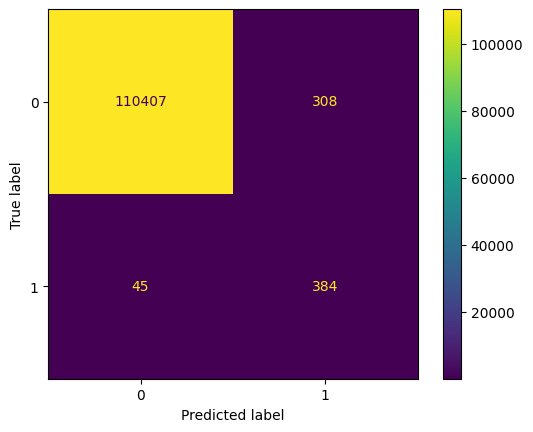

In [122]:
testScores( xgb , xtest , ytest )

In [123]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [124]:
abc = AdaBoostClassifier(
     estimator=DecisionTreeClassifier(class_weight='balanced'),
    n_estimators = 100 ,
    
)

avgAcc = []

for i , (train_idx, test_idx) in enumerate ( skf.split(rTrain, rTest) ) :
    #train rnd classifet
    X_tr, X_te = rTrain.iloc[train_idx], rTrain.iloc[test_idx]
    y_tr, y_te = rTest.iloc[train_idx], rTest.iloc[test_idx]


    abc.fit(X_tr, y_tr)
    preds = abc.predict(X_te)

    acc = accuracy_score(y_te, preds)
    avgAcc.append(acc)
    print(f"Fold {i+1} Accuracy: {acc:.4f}")

print(f"Average Accuracy : {(sum(avgAcc) / 5):.4f}")

Fold 1 Accuracy: 0.9878
Fold 2 Accuracy: 0.9880
Fold 3 Accuracy: 0.9873
Fold 4 Accuracy: 0.9857
Fold 5 Accuracy: 0.9862
Average Accuracy : 0.9870


╒═══════════╤═════════╕
│ Metric    │   Score │
╞═══════════╪═════════╡
│ Accuracy  │  0.9892 │
├───────────┼─────────┤
│ Precision │  0.2361 │
├───────────┼─────────┤
│ Recall    │  0.8042 │
├───────────┼─────────┤
│ F1 Score  │  0.3651 │
╘═══════════╧═════════╛


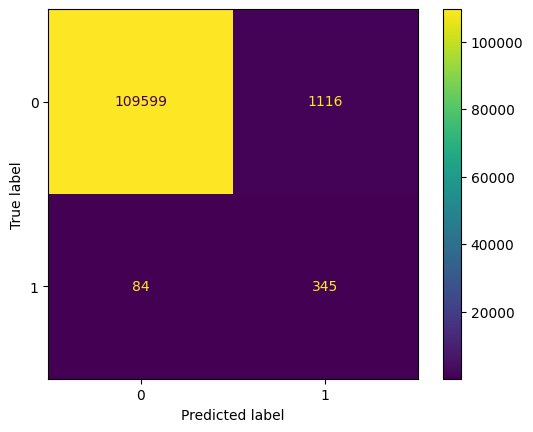

In [125]:
testScores( abc , xtest , ytest )

In [134]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb),
        ('rf', rdf),
        ('abc' , abc)
    ],
    voting='hard'  ,
    n_jobs = -1
)

In [135]:
avgAcc = []

for i , (train_idx, test_idx) in enumerate ( skf.split(rTrain, rTest) ) :
    #train rnd classifet
    X_tr, X_te = rTrain.iloc[train_idx], rTrain.iloc[test_idx]
    y_tr, y_te = rTest.iloc[train_idx], rTest.iloc[test_idx]


    voting_clf.fit(X_tr, y_tr)
    preds = voting_clf.predict(X_te)

    acc = accuracy_score(y_te, preds)
    avgAcc.append(acc)
    print(f"Fold {i+1} Accuracy: {acc:.4f}")

print(f"Average Accuracy : {(sum(avgAcc) / 5):.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Fold 1 Accuracy: 0.9959


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Fold 2 Accuracy: 0.9957


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Fold 3 Accuracy: 0.9955


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Fold 4 Accuracy: 0.9955


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Fold 5 Accuracy: 0.9954
Average Accuracy : 0.9956


╒═══════════╤═════════╕
│ Metric    │   Score │
╞═══════════╪═════════╡
│ Accuracy  │  0.9962 │
├───────────┼─────────┤
│ Precision │  0.5056 │
├───────────┼─────────┤
│ Recall    │  0.8392 │
├───────────┼─────────┤
│ F1 Score  │  0.6310 │
╘═══════════╧═════════╛


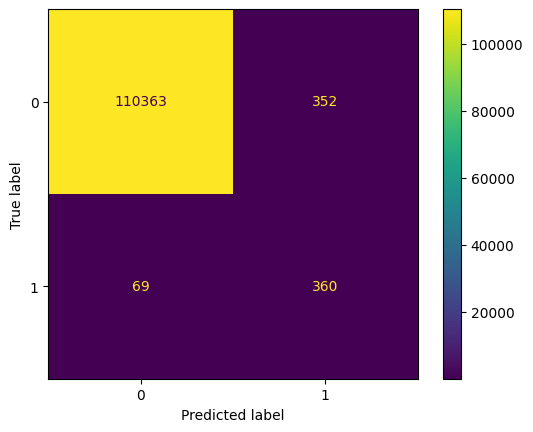

In [136]:
testScores( voting_clf , xtest , ytest )

In [138]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [139]:
stacking_clf = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('rf', rdf),
        ('abc', abc)
    ],
    final_estimator=LogisticRegression(class_weight='balanced'),
    n_jobs=-1,
)

In [140]:
avgAcc = []

for i, (train_idx, test_idx) in enumerate(skf.split(rTrain, rTest)):
    X_tr, X_te = rTrain.iloc[train_idx], rTrain.iloc[test_idx]
    y_tr, y_te = rTest.iloc[train_idx], rTest.iloc[test_idx]

    stacking_clf.fit(X_tr, y_tr)
    preds = stacking_clf.predict(X_te)

    acc = accuracy_score(y_te, preds)
    avgAcc.append(acc)
    print(f"Fold {i+1} Accuracy: {acc:.4f}")

print(f"Average Accuracy: {sum(avgAcc)/len(avgAcc):.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

Fold 1 Accuracy: 0.9968


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

Fold 2 Accuracy: 0.9963


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

Fold 3 Accuracy: 0.9965


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

Fold 4 Accuracy: 0.9964


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

Fold 5 Accuracy: 0.9964
Average Accuracy: 0.9965


╒═══════════╤═════════╕
│ Metric    │   Score │
╞═══════════╪═════════╡
│ Accuracy  │  0.9965 │
├───────────┼─────────┤
│ Precision │  0.5264 │
├───────────┼─────────┤
│ Recall    │  0.8834 │
├───────────┼─────────┤
│ F1 Score  │  0.6597 │
╘═══════════╧═════════╛


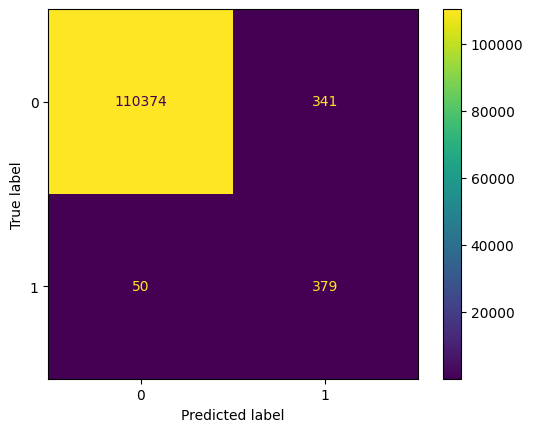

In [141]:
testScores( stacking_clf , xtest , ytest )